In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json

import sys
sys.path.append('../0 utils/')
from tool import *

data_root = '../../MyData/'

## Load data

In [2]:
item1_embedding = pd.read_csv(data_root+'merged_1197.csv')
item1_embedding = item1_embedding[['cik', 'tic', 'Year', 'item1_embeddings']]
print(len(item1_embedding))
print(item1_embedding.head())

other_embedding = pd.read_csv(data_root+'output_embeddings_2.csv')
other_embedding = other_embedding[['cik', 'SP_SHORT_DESC_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']]
print(len(other_embedding))
print(other_embedding.head())

total_embedding = pd.merge(item1_embedding, other_embedding, on=['cik'])

# To reduce mem consumption
item1_embedding = ''
other_embedding = ''

print(len(total_embedding))
total_embedding.head()

1197
       cik   tic  Year                                   item1_embeddings
0   850460  WIRE  2021  [0.03955410048365593, -0.04159577935934067, -0...
1   352541   LNT  2021  [-0.0231856107711792, 0.001279839314520359, 0....
2  1704715   AMR  2021  [0.014074714854359627, 0.006938479840755463, 0...
3  1575515   SFM  2021  [-0.023708730936050415, 0.01762891560792923, 0...
4  1125376  ENSG  2021  [0.04463111609220505, 0.0018805989529937506, 0...
1197
       cik                           SP_SHORT_DESC_embeddings  \
0   850460  [0.01568225771188736, -0.07636360824108124, -0...   
1   352541  [-0.013836896046996117, -0.028995024040341377,...   
2  1704715  [0.0030535957776010036, 0.0008783274097368121,...   
3  1575515  [-0.025762900710105896, 0.0034106436651200056,...   
4  1125376  [0.04616139456629753, -0.0021259395871311426, ...   

                             SP_LONG_DESC_embeddings  \
0  [0.06089901179075241, -0.07059630751609802, -0...   
1  [-0.021961161866784096, 0.02030270546674

,cik,tic,Year,item1_embeddings,SP_SHORT_DESC_embeddings,SP_LONG_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,"[0.03955410048365593, -0.04159577935934067, -0...","[0.01568225771188736, -0.07636360824108124, -0...","[0.06089901179075241, -0.07059630751609802, -0...",NaN,NaN
1,352541,LNT,2021,"[-0.0231856107711792, 0.001279839314520359, 0....","[-0.013836896046996117, -0.028995024040341377,...","[-0.021961161866784096, 0.020302705466747284, ...","[-0.015400929376482964, 0.03232719004154205, -...","[-0.041709959506988525, -0.011898815631866455,..."
2,1704715,AMR,2021,"[0.014074714854359627, 0.006938479840755463, 0...","[0.0030535957776010036, 0.0008783274097368121,...","[-0.0017570963827893138, 0.006557094398885965,...","[-0.02030838653445244, -0.009386725723743439, ...","[-0.012340557761490345, -0.01428779773414135, ..."
3,1575515,SFM,2021,"[-0.023708730936050415, 0.01762891560792923, 0...","[-0.025762900710105896, 0.0034106436651200056,...","[-0.015190708450973034, 0.011541897431015968, ...","[-0.013177500106394291, 0.036401789635419846, ...","[-0.01883152313530445, 0.021741388365626335, 0..."
4,1125376,ENSG,2021,"[0.04463111609220505, 0.0018805989529937506, 0...","[0.04616139456629753, -0.0021259395871311426, ...","[0.05935207009315491, 0.0013673527864739299, 0...","[0.029405493289232254, 0.014010551385581493, 0...","[-0.006068837363272905, 0.010537531226873398, ..."


### Check dataset

In [3]:
nan_proportion = total_embedding.isna().mean()
print(f"The nan value proportion in each column:\n{nan_proportion}\n\n")

The nan value proportion in each column:
cik                           0.000000
tic                           0.000000
Year                          0.000000
item1_embeddings              0.000000
SP_SHORT_DESC_embeddings      0.041771
SP_LONG_DESC_embeddings       0.095238
ORBIS_PROD_SERV_embeddings    0.208020
ORBIS_OVERVIEW_embeddings     0.168755
dtype: float64




## Define fusion function

In [4]:
# Fusion function that can handle nan modalities
def additive_fusion(data_df, target_list):
    modality_content_list = []
    # Traverse columns that will be fused.
    for target in target_list:
        modality_content_list.append(list(data_df[target].apply(
            lambda x: json.loads(x) if pd.notna(x) else np.full(1536, np.nan)
            )))
    
    # Convert to a NumPy array
    modality_content_array = np.array(modality_content_list)  # Shape: (3, 1197, 1536)
    
    # Create a mask for valid (non-NaN) values
    valid_mask = ~np.isnan(modality_content_array)  # Shape: (3, 1197, 1536)
    
    # Replace NaN with 0 for summation
    modality_content_array = np.nan_to_num(modality_content_array, nan=0.0)
    
    # Sum along modalities (axis=0) and count valid values
    summed_features = np.sum(modality_content_array, axis=0)  # Shape: (1197, 1536)
    valid_counts = np.sum(valid_mask, axis=0)  # Shape: (1197, 1536)
    
    # Avoid division by zero and calculate the average
    average_features = summed_features / np.maximum(valid_counts, 1)
    
    return average_features

## Experiment 1:

Using the mean of item1, sp_long, orbis_overview

In [7]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_OVERVIEW_embeddings']
fused_np = additive_fusion(total_embedding, target_list)
print(fused_np.shape)

(1197, 1536)


In [8]:
exp1_df = total_embedding[['cik', 'tic', 'Year']].copy()
exp1_df['cluster_10'] = cluster(fused_np, 10)
exp1_df['cluster_100'] = cluster(fused_np, 100)
exp1_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.0002320063167416752
Normalized Within-Cluster Sum of Squares (WCSS): 0.00017162313610915125


,cik,tic,Year,cluster_10,cluster_100
0,850460,WIRE,2021,2,31
1,352541,LNT,2021,6,9
2,1704715,AMR,2021,4,77
3,1575515,SFM,2021,3,99
4,1125376,ENSG,2021,7,54
...,...,...,...,...,...
1192,1021860,NOV,2021,4,50
1193,1744489,DIS,2021,0,32
1194,1102112,PACW,2021,1,98
1195,28823,DBD,2021,8,64


In [9]:
# exp1_df.to_csv('2_average_clusters.csv', index=False)

### Evaluate

In [7]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
# returns_long = fetch_stock_data(exp1_df, year, mode)
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp1_returns = pd.merge(exp1_df, returns_long, on='tic', how='inner')

exp1_intra_corrs_10 = intra_industry_correlations(exp1_returns, "cluster_10")
exp1_avg_intra_corr_10 = np.nanmean(list(exp1_intra_corrs_10.values()))
print(exp1_avg_intra_corr_10)

exp1_intra_corrs_100 = intra_industry_correlations(exp1_returns, "cluster_100")
exp1_avg_intra_corr_100 = np.nanmean(list(exp1_intra_corrs_100.values()))
print(exp1_avg_intra_corr_100)

print(len(exp1_returns['cik'].unique()))

0.3806188005689559
0.43680302475561966
1064


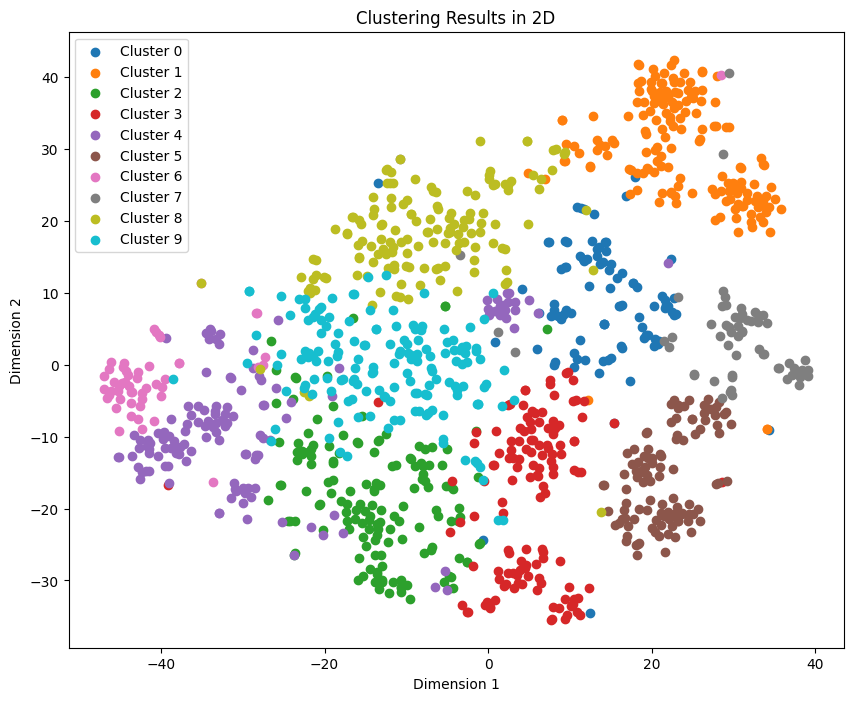

In [8]:
show_cluster_graph(fused_np, exp1_df['cluster_10'])

## Experiment 2:

Using the mean of item1, sp_short, sp_long

In [9]:
target_list = ['item1_embeddings', 'SP_SHORT_DESC_embeddings', 'SP_LONG_DESC_embeddings']
fused_np = additive_fusion(total_embedding, target_list)
print(fused_np.shape)

(1197, 1536)


In [10]:
exp2_df = total_embedding[['cik', 'tic', 'Year']].copy()
exp2_df['cluster_10'] = cluster(fused_np, 10)
exp2_df['cluster_100'] = cluster(fused_np, 100)
exp2_df

Cluster Labels: [2 4 4 ... 6 9 1]
Cluster Centers: [[-0.00686137  0.00844431  0.02953827 ...  0.00784771  0.02355042
   0.00121187]
 [-0.01442967  0.00378214  0.03578983 ...  0.01574077  0.0076424
   0.00782158]
 [-0.00500293  0.00508433  0.04271416 ...  0.00197719  0.01263265
   0.00668214]
 ...
 [-0.0009997   0.01240231  0.04861354 ...  0.00554628  0.01999144
   0.00814716]
 [ 0.00021323  0.00639549  0.03419191 ...  0.00076179  0.01610341
   0.00744412]
 [-0.014068   -0.00367425  0.0458233  ... -0.00010436  0.01380944
   0.00392085]]
Within-Cluster Sum of Squares (WCSS): 497.8308722578123
Cluster Labels: [31 17 58 ... 36 84 55]
Cluster Centers: [[ 0.01398295  0.04706792  0.03040364 ...  0.01841276  0.03809445
   0.01722407]
 [-0.00054807  0.00820071  0.03704173 ... -0.00397909  0.0173299
   0.0018178 ]
 [-0.00335676  0.02455946  0.05636942 ... -0.01574893  0.01848797
  -0.01162971]
 ...
 [-0.02914095  0.03065954  0.02912507 ...  0.00118783  0.00963293
   0.02724734]
 [ 0.00269497  0.

,cik,tic,Year,cluster_10,cluster_100
0,850460,WIRE,2021,2,31
1,352541,LNT,2021,4,17
2,1704715,AMR,2021,4,58
3,1575515,SFM,2021,0,94
4,1125376,ENSG,2021,7,89
...,...,...,...,...,...
1192,1021860,NOV,2021,4,22
1193,1744489,DIS,2021,8,10
1194,1102112,PACW,2021,6,36
1195,28823,DBD,2021,9,84


### Evaluate

In [11]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
# returns_long = fetch_stock_data(exp2_df, year, mode)
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp2_returns = pd.merge(exp2_df, returns_long, on='tic', how='inner')
exp2_intra_corrs_10 = intra_industry_correlations(exp2_returns, "cluster_10")
exp2_avg_intra_corr_10 = np.nanmean(list(exp2_intra_corrs_10.values()))
print(exp2_avg_intra_corr_10)
exp2_intra_corrs_100 = intra_industry_correlations(exp2_returns, "cluster_100")
exp2_avg_intra_corr_100 = np.nanmean(list(exp2_intra_corrs_100.values()))
print(exp2_avg_intra_corr_100)
print(len(exp2_returns['cik'].unique()))

0.364476565870326
0.4367439446428272
1064


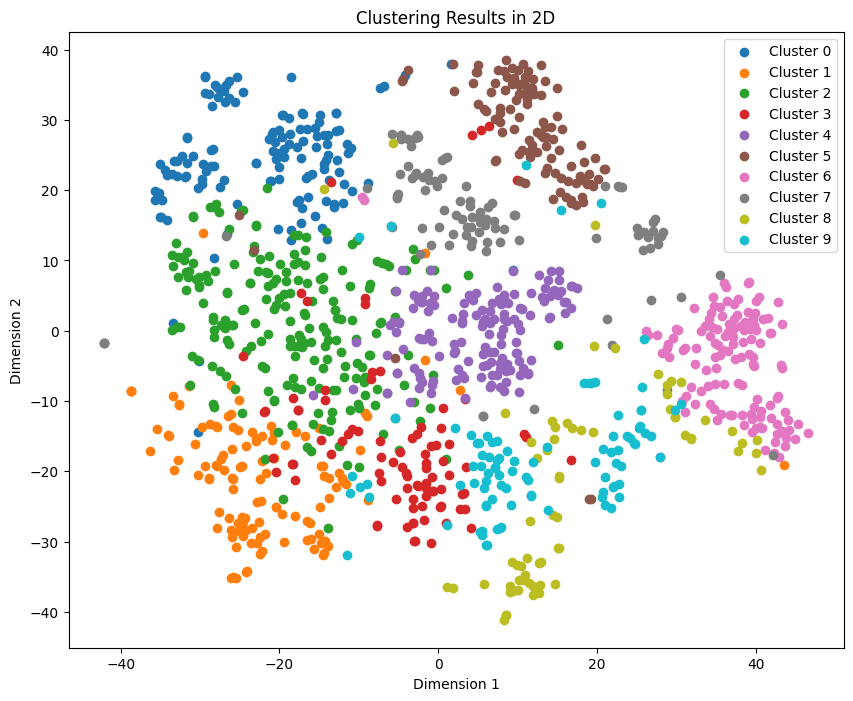

In [12]:
show_cluster_graph(fused_np, exp2_df['cluster_10'])